In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [2]:
flight_data = pd.read_csv('Clean_Dataset.csv')
flight_data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
flight_data.shape

(300153, 12)

Because there 300153 rows, I limited the data to ~ 50,000 rows so the training of the model wouldn't take a very long time on my laptop.

In [4]:
#Randomly sampling 50,000 rows to use as our data. random_state is for reproducibility.
flight_data = flight_data.sample(n = 5000, random_state = 42)

In [5]:
flight_data.describe()

,Unnamed: 0,duration,days_left,price
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,149433.774400,12.242940,26.063400,20876.018400
std,86874.189529,7.119469,13.500809,22900.048039
min,16.000000,0.920000,1.000000,1105.000000
25%,73741.500000,6.830000,15.000000,4792.000000
50%,150110.000000,11.330000,26.000000,7344.000000
75%,225586.500000,16.170000,38.000000,42521.000000
max,300089.000000,36.830000,49.000000,114705.000000


In [6]:
flight_data.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [7]:
flight_data.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [8]:
flight_data['flight'].nunique()

904

In [9]:
flight_data.drop(['Unnamed: 0', 'flight'], axis = 1, inplace = True)

In [10]:
#Splitting categorical and numerical columns for EDA and for preprocessing
numeric = flight_data.select_dtypes([np.number])
categorical = flight_data.drop(['duration', 'days_left', 'price'], axis = 1)

## EDA

In [11]:
#function to draw histograms for each column
def draw_hist(df, columns):
    for i in columns:
        sns.histplot(data = df[i])
        plt.show()

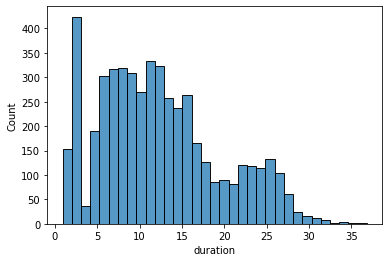

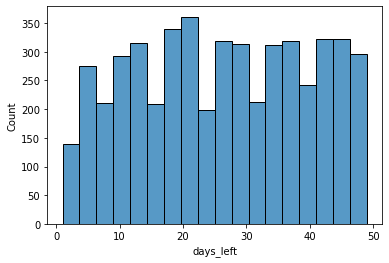

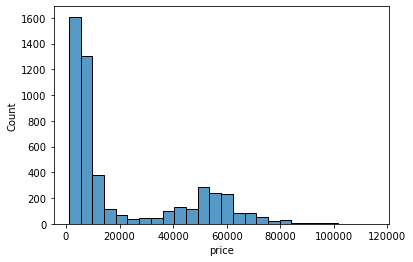

In [12]:
draw_hist(flight_data, numeric)

In [13]:
#Note: why histogram of days_left have gap?

In [14]:
#countplots
def draw_count(df, columns):
    for i in columns:
        sns.countplot(x = df[i])
        plt.show()

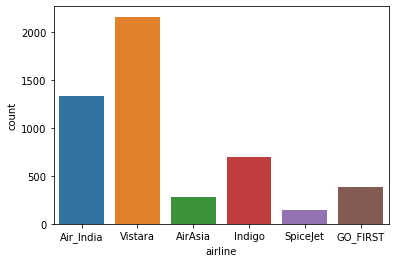

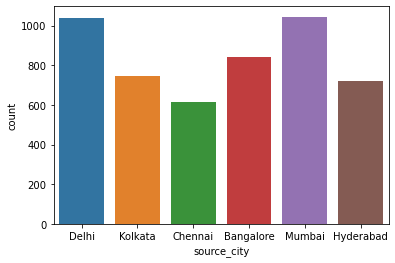

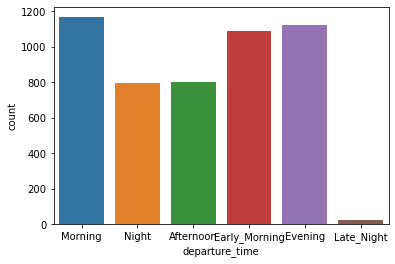

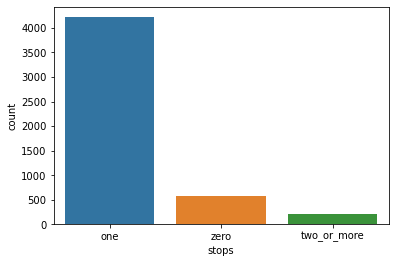

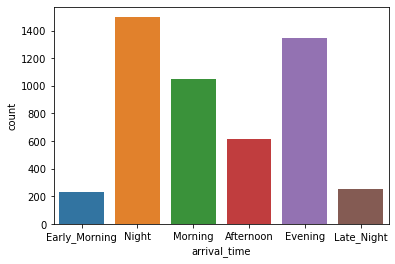

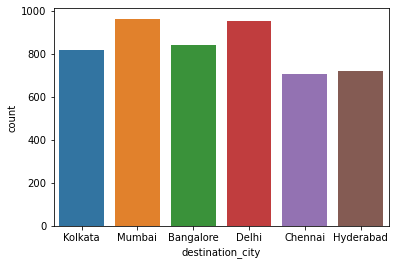

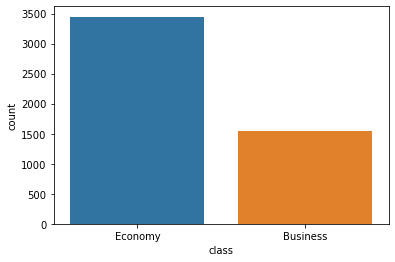

In [15]:
draw_count(flight_data, categorical)

Just by examining the column names, here are some categorical features I wanted to investigate as they related to price

In [16]:
hue_list = ['airline', 'departure_time', 'stops', 'class']

In [17]:
def draw_hue_hist(df, feature_list):
    for i in feature_list:
        sns.histplot(x = df['price'], hue = df[i], bins = 20)
        plt.show()

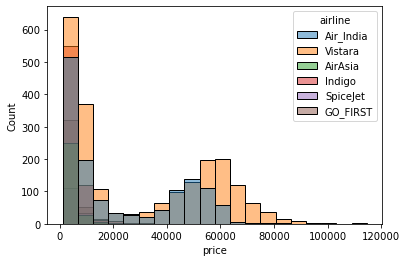

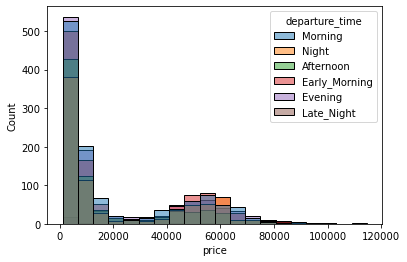

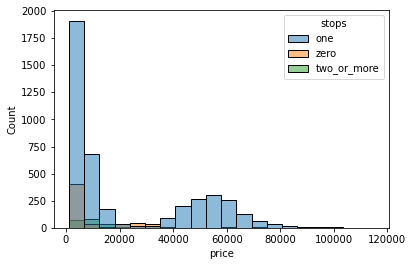

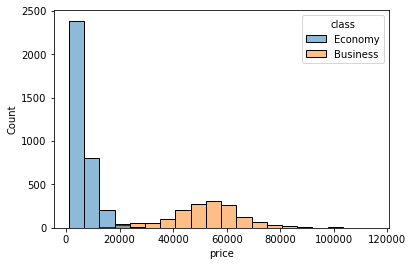

In [18]:
draw_hue_hist(flight_data, hue_list)

airline and departure_time have a lot of unique categories, so it is hard to see the differences in the distributions of those categories. We can try looking at the median price grouped by departure_time and airline separately. 

In [19]:
flight_data.groupby('airline').median()

,duration,days_left,price
airline,,,
AirAsia,9.42,29.0,3090.0
Air_India,15.58,25.0,10680.0
GO_FIRST,8.79,27.0,5618.0
Indigo,6.08,27.0,4453.0
SpiceJet,10.17,24.0,5330.0
Vistara,12.42,26.0,15554.0


In [20]:
flight_data.groupby('departure_time').median()

,duration,days_left,price
departure_time,,,
Afternoon,8.080,26.0,6450.0
Early_Morning,11.830,26.0,7585.0
Evening,14.670,26.0,7135.0
Late_Night,6.420,28.0,4020.0
Morning,10.080,26.0,7854.0
Night,13.415,26.0,7352.0


There are also some numerical features I wanted to explore

In [21]:
numeric_scatter_list = ['duration', 'days_left']

In [22]:
def draw_scatter(df, scatter_list):
    for i in scatter_list:
        sns.scatterplot(x = df[i], y = df['price'])
        plt.show()

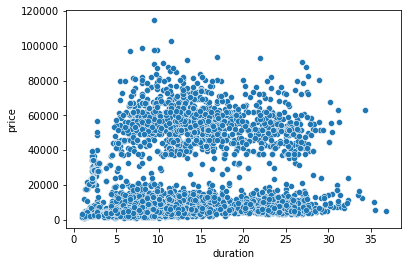

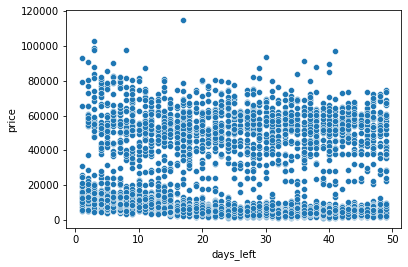

In [23]:
draw_scatter(flight_data, numeric_scatter_list)

In [24]:
#Can't make out much from the graphs

Correlations

In [25]:
def corr_matrix(df):
    fig, ax = plt.subplots(figsize = (10, 10))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

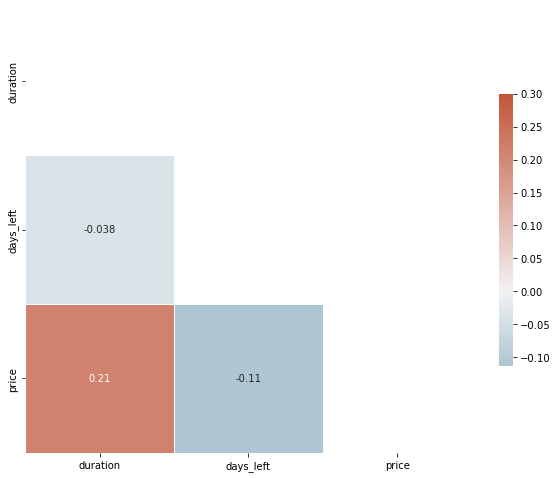

In [26]:
corr_matrix(flight_data)

# Creating Pipeline

## Preprocessing:  
Since there are no null values, we just have to perform the following transformations to our data:  
  
  1. Scale numeric data
  2. One hot encode categorical data

In [27]:
#Separating features and target
X = flight_data.drop('price', axis = 1)
y = flight_data['price']

In [28]:
#Creating OneHotEncoder and StandardScaler objects
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
scaler = StandardScaler()

In [29]:
#dropping price (the target) from our numeric columns
numeric.drop('price', axis = 1, inplace = True)

In [30]:
#Creating a column transformer
column_trans = make_column_transformer((ohe, list(categorical.columns)), (scaler, list(numeric.columns)), remainder = 'passthrough')
column_trans.fit_transform(X)

array([[ 0.        ,  1.        ,  0.        , ...,  1.        ,
         1.05454639,  1.03238215],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.33895522,  1.18053624],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.24483767,  1.10645919],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         1.92127067,  0.06938056],
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         1.6627986 , -1.48623739],
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
        -0.83061405, -0.30100467]])

In [31]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
pipe_lin = make_pipeline(column_trans, linreg)

In [32]:
cross_val_score(pipe_lin, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-6968.313709862001

In [46]:
from sklearn.linear_model import Lasso
lassoreg = Lasso()
pipe_lasso = make_pipeline(column_trans, lassoreg)

In [34]:
cross_val_score(pipe_lasso, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-6966.597444621087

In [37]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor()
pipe_tree = make_pipeline(column_trans, treereg)

In [38]:
cross_val_score(pipe_tree, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-6258.700028458547

In [39]:
xgbreg = xgb.XGBRegressor()
pipe_xgb = make_pipeline(column_trans, xgbreg)

In [40]:
cross_val_score(pipe_xgb, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-4714.975916918241

In [73]:
#perform a gridsearch for lasso, decision tree, xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [121]:
#Create a function that does the gridsearch and returns the best score and the best parameters 
def tune_model(pipe, pipe_params, X, y):
    search = RandomizedSearchCV(pipe, pipe_params, scoring = 'neg_root_mean_squared_error', n_iter = 50)
    search.fit(X,y)
    return search.best_score_, search.best_estimator_

In [122]:
#Lasso gridsearch
lasso_params = {
    'lasso__alpha' : [0.25, 0.5, 0.75, 0.9, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]
}
lasso_score, lasso_best_params = tune_model(pipe_lasso, lasso_params, X, y)

c:\Users\kevoi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 15 is smaller than n_iter=50. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [123]:
lasso_score

-6965.649262384986

In [124]:
lasso_best_params

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration', 'days_left'])])),
                ('lasso', Lasso(alpha=10))])

In [140]:
#Decision Tree gridsearch
#Credit for parameters: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
tree_params = {
    "decisiontreeregressor__splitter" : ['best', 'random'],
    "decisiontreeregressor__max_depth" : [None],
    "decisiontreeregressor__min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    "decisiontreeregressor__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
    "decisiontreeregressor__max_features":["auto","log2","sqrt",None],
    "decisiontreeregressor__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] ,
    "decisiontreeregressor__random_state" : [42]
}
tree_score, tree_best_params = tune_model(pipe_tree, tree_params, X, y)

In [141]:
tree_score

-7431.442784772196

In [142]:
tree_best_params

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration', 'days_left'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_features='

In [148]:
#xgboost gridsearch
#credit for parameters: https://github.com/krishnaik06/Hyperparameter-Optimization/blob/master/Hyperparameter%20Optimization%20For%20Xgboost.ipynb
xgb_params = {
    "xgbregressor__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "xgbregressor__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "xgbregressor__min_child_weight" : [ 1, 3, 5, 7 ],
    "xgbregressor__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "xgbregressor__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]   
}
xgb_score, xgb_best_params = tune_model(pipe_xgb, xgb_params, X, y)

In [149]:
xgb_score

-4596.770275429973

In [152]:
xgb_best_params

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration', 'days_left'])])),
                ('xgbregressor',
                 XGBRegressor(b...
                           

In [154]:
final_pipe = xgb_best_params
cross_val_score (final_pipe, X, y, cv = 5, scoring = 'neg_root_mean_squared_error').mean()

-4596.770275429973